<h1>SVM<h1>
    <h5>We solve the tweet classification problem using SVM. Additionally, we study the effect of the context annotations information from the twitter API<h5>

In [1]:
#importing libraries
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import re
import dill
from sklearn import metrics
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
#helper for generating performance report
def performance(y_true,y_predict,y_proba):
    TP = confusion_matrix(y_true,y_predict)[0,0]
    FP = confusion_matrix(y_true,y_predict)[0,1]
    TN = confusion_matrix(y_true,y_predict)[1,1]
    FN = confusion_matrix(y_true,y_predict)[1,0]
    TN, FP, FN, TP = confusion_matrix(y_true,y_predict).ravel()
    print(f"Accuracy: {round(((TP+TN)/(TP+TN+FP+FN))*100,3)}%")
    precision = round((TP/(TP+ FP))*100,3)
    recall = round((TP/(TP+ FN))*100,3)
    print(confusion_matrix(y_true,y_predict,labels=[1,0]).ravel())
    print(f"TP: {TP}")
    print(f"FP: {FP}")
    print(f"TN: {TN}")
    print(f"FN: {FN}")
    print(f"Sensitivity: {round((TP/(TP+ FN))*100,3)}%")
    print(f"Specificity: {round((TN/(TN + FP))*100,3)}%")
    print(f"Precision: {precision}%")
    print(f"Recall: {recall}%")
    print(f"f1: {round(((2*precision*recall)/(precision+recall)),3)}%")
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix(y_true,y_predict,labels=[1,0]), display_labels=[1,0])
    cm_display.plot()
    plt.show()
    
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_true,y_proba)
    area = metrics.auc(false_positive_rate, true_positive_rate)
    plt.figure()
    plt.plot(false_positive_rate, true_positive_rate, color='green', lw=2, label=f'ROC curve (Area Under Curve = {area:.2f})')
    plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [4]:
#dill.load_session('./svm_context.db')

In [5]:
#load the raw tweet dataset
train_df = pd.read_pickle('./train_df.pkl')
test_df = pd.read_pickle('./test_df.pkl')

In [6]:
#load the cleaned tweet dataset
train_df_cleaned = pd.read_pickle('./train_df_cleaned.pkl')
test_df_cleaned = pd.read_pickle('./test_df_cleaned.pkl')

In [8]:
#check for equal class distribution in train set
train_df['related_manual'].value_counts()

related_manual
0.0    1000
1.0    1000
Name: count, dtype: int64

In [9]:
#check for equal class distribution in test set
test_df['related_manual'].value_counts()

related_manual
1.0    250
0.0    250
Name: count, dtype: int64

In [4]:
#define parameter options for gridsearch
param_grid = {'C':[0.1,1,10],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf']}

First, let us run the SVM model on the transformed tweet dataset (raw tweets).
We transform the tweet dataset by adding the word2vec embedding of raw tweets with the word2vec representation of the context field

In [11]:
#Add the raw tweet word2vec vectors to the context word2vec vectors
train_df_transformed = train_df['tweet_word2vec_original']+train_df['context_word2vec']
test_df_transformed = test_df['tweet_word2vec_original']+test_df['context_word2vec']

In [13]:
#initialise grid
grid = GridSearchCV(SVC(probability=True),param_grid,refit = True, verbose=2, n_jobs=-1)

In [14]:
%%time
#fit the transformed data
grid.fit(list(train_df_transformed), train_df.related_manual)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
CPU times: user 12.4 s, sys: 1.34 s, total: 13.7 s
Wall time: 1min 24s


GridSearchCV(estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.001, 0.0001],
                         'kernel': ['linear', 'rbf']},
             verbose=2)

In [15]:
#best grid estimator
grid.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

In [16]:
%%time
#predict class probablities
preds = grid.predict_proba(list(test_df_transformed))

CPU times: user 57 ms, sys: 1.62 ms, total: 58.6 ms
Wall time: 58.1 ms


In [17]:
#convert into binary class predictions
preds_binary = preds[:,1] >= 0.5
preds_binary = preds_binary.astype(np.int64) 

Accuracy: 93.8%
[238  12  19 231]
TP: 238
FP: 19
TN: 231
FN: 12
Sensitivity: 95.2%
Specificity: 92.4%
Precision: 92.607%
Recall: 95.2%
f1: 93.886%


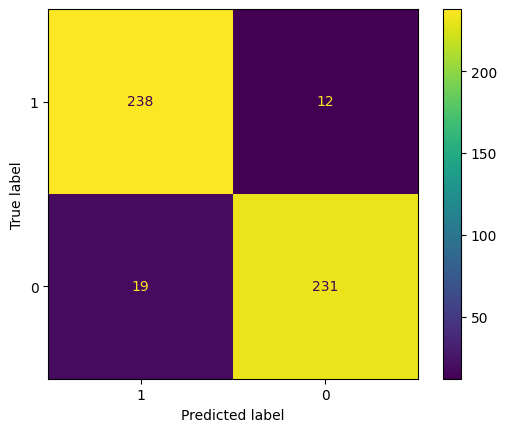

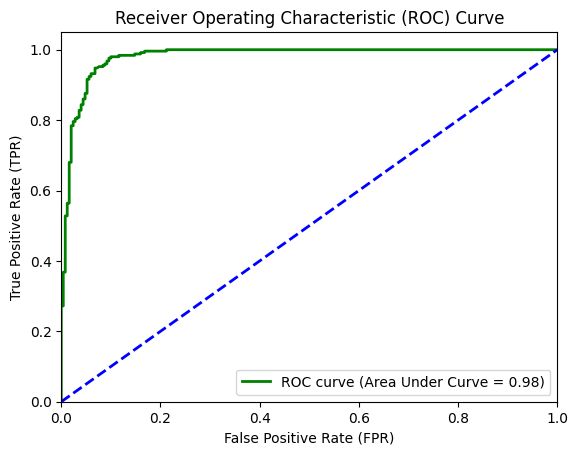

In [20]:
#generate performance report
performance(test_df.related_manual,preds_binary,preds[:,1])

Now let us repeat the same experiment with cleaned tweets

In [7]:
#Add the cleaned tweet word2vec vectors to the context word2vec vectors
train_df_transformed_cleaned = (train_df_cleaned['tweet_word2vec_preprocessed']+train_df_cleaned['context_word2vec'])
test_df_transformed_cleaned = (test_df_cleaned['tweet_word2vec_preprocessed']+test_df_cleaned['context_word2vec'])

In [8]:
grid_cleaned = GridSearchCV(SVC(probability=True),param_grid,refit = True, verbose=2, n_jobs=-1)

In [10]:
%%time
grid_cleaned.fit(list(train_df_transformed_cleaned), train_df_cleaned.related_manual)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
CPU times: user 11.6 s, sys: 1.32 s, total: 12.9 s
Wall time: 1min 19s


GridSearchCV(estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.001, 0.0001],
                         'kernel': ['linear', 'rbf']},
             verbose=2)

In [29]:
grid_cleaned.best_params_

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

In [11]:
%%time
preds_cleaned = grid_cleaned.predict_proba(list(test_df_transformed_cleaned))

CPU times: user 64.2 ms, sys: 2.44 ms, total: 66.7 ms
Wall time: 65.8 ms


In [12]:
preds_binary_cleaned = preds_cleaned[:,1] >= 0.5
preds_binary_cleaned = preds_binary_cleaned.astype(np.int64) 

Accuracy: 92.2%
[232  18  21 229]
TP: 232
FP: 21
TN: 229
FN: 18
Sensitivity: 92.8%
Specificity: 91.6%
Precision: 91.7%
Recall: 92.8%
f1: 92.247%


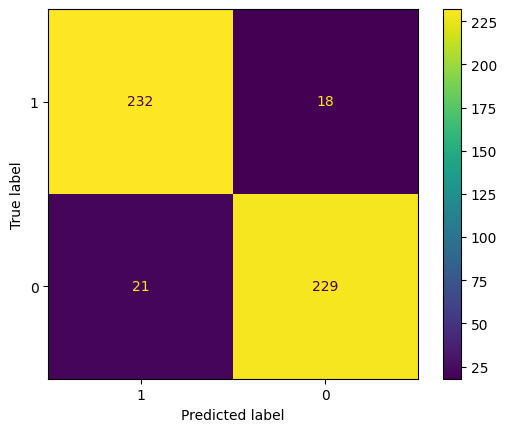

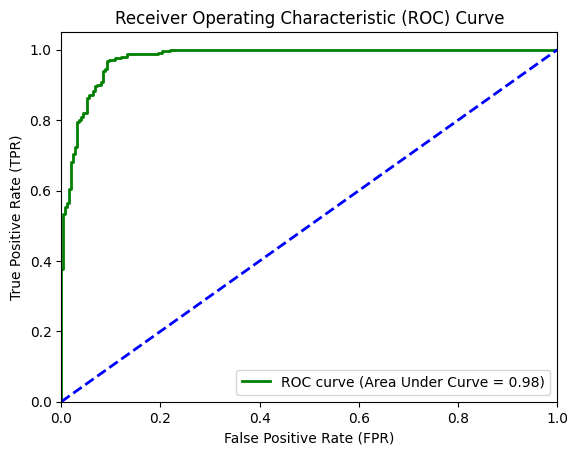

[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   4.9s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   4.5s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   8.0s
[CV] END .................C=0.1, gamma=0.0001, kernel=linear; total time=   4.6s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=   3.1s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=   3.6s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=   3.1s
[CV] END ......................C=1, gamma=0.1, kernel=linear; total time=   3.4s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   4.5s
[CV] END ....................C=1, gamma=0.001, kernel=linear; total time=   3.4s
[CV] END ...................C=1, gamma=0.0001, kernel=linear; total time=   3.5s
[CV] END ......................C=1, gamma=0.0001, kernel=rbf; total time=  14.1s
[CV] END ...................

In [13]:
performance(test_df_cleaned.related_manual,preds_binary_cleaned,preds_cleaned[:,1])

<h2>Results<h2>
<h5>Clearly, SVM gives better results with the raw tweets and with following hyperparamteters
    <ol><li>kernel - rbf</li>
        <li>gamma - 0.1</li>
        <li>C - 10</li></ol><h5><br>

| Model                    | Accuracy | TP  | FP | TN  | FN | Sensitivity | Specificity | Precision | Recall | f1-score |
|--------------------------|----------|-----|----|-----|----|-------------|-------------|-----------|--------|----------|
| SVM with context feature | 93.8%    | 238 | 19 | 231 | 12 | 95.2%       | 92.4%       | 92.607%   | 95.2%  | 93.886%  |

<h5>It is also to be noted that adding the context information reduces the accuracy and performance of the model.
    <h5>

In [38]:
dill.dump_session('./svm_context.db')

[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   7.4s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  12.8s
[CV] END .................C=0.1, gamma=0.0001, kernel=linear; total time=   5.9s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=   4.6s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=   3.8s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   7.5s
[CV] END ....................C=1, gamma=0.001, kernel=linear; total time=   3.9s
[CV] END ...................C=1, gamma=0.0001, kernel=linear; total time=   3.7s
[CV] END ......................C=1, gamma=0.0001, kernel=rbf; total time=  14.2s
[CV] END ........................C=10, gamma=0.1, kernel=rbf; total time=   3.7s
[CV] END ......................C=10, gamma=0.001, kernel=rbf; total time=   8.6s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   3.3s
[CV] END ...................